In [1]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np
from valleyfloor.process_topography import process_topography
from valleyfloor.utils import setup_wbt

from slopes.subbasins import label_subbasins
from slopes.hillslopes import label_hillslopes
from slopes.network_xsections import network_xsections, observe_values

logger.enable("valleyfloor")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
wbt = setup_wbt("~/opt/WBT/", "../working_dir")

dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
flowlines = gpd.read_file("../data/input/flowlines.shp")

In [3]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt)
aligned_flowlines = gpd.GeoSeries(aligned_flowlines['geometry'].values, index=aligned_flowlines['Stream_ID'])

subbasins = label_subbasins(dataset['flow_dir'], dataset['flow_acc'], dataset['flowpaths'], wbt)
hillslopes = label_hillslopes(dataset['flowpaths'], dataset['flow_dir'], subbasins, wbt)
dataset['hillslope'] = hillslopes
dataset['subbasins'] = subbasins

2024-10-14 10:41:52.117 | INFO     | valleyfloor.process_topography:process_topography:36 - process topography
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-hCrF487D-py3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [4]:
dataset['flowpaths'].rio.to_raster("../working_dir/flowpaths.tif")

In [22]:
xs = network_xsections(aligned_flowlines, 10, 40, 2, subbasins=subbasins)

In [23]:
xs = observe_values(xs, dataset[['conditioned_dem', 'hand', 'slope', 'curvature', 'hillslope', 'flowpaths']])

In [39]:
stream_xs = xs.loc[xs['streamID'] == 10]
sample = stream_xs.loc[stream_xs['xsID'] == 52].sort_values('alpha')
mid = sample.loc[np.isfinite(sample['flowpaths']), 'alpha']

In [40]:
from slopes.segment_profile import *

In [41]:
labels, bps = mean_shift(sample['slope'].values)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

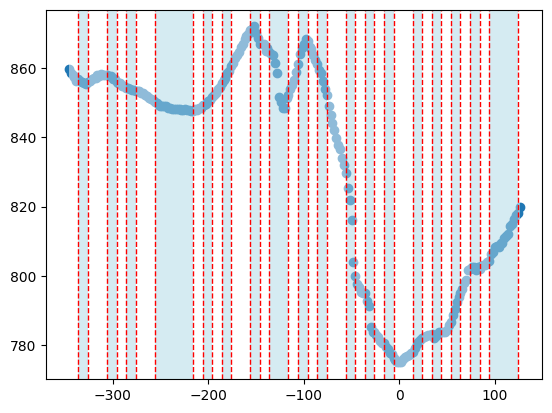

In [42]:
plot_segments(sample['alpha'], sample['conditioned_dem'], labels, bps)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

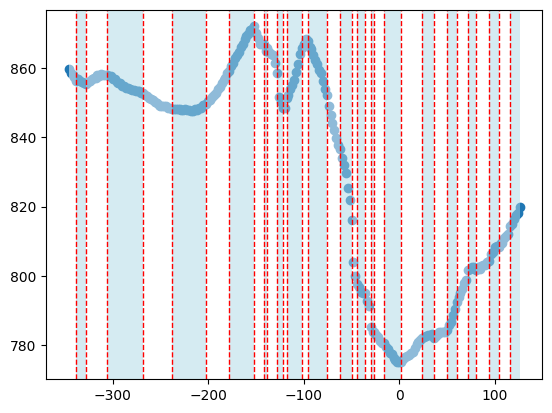

In [43]:
labels, bps = elevation_simplification(sample['conditioned_dem'], sample['alpha'], epsilon=0.5)
plot_segments(sample['alpha'], sample['conditioned_dem'], labels, bps)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

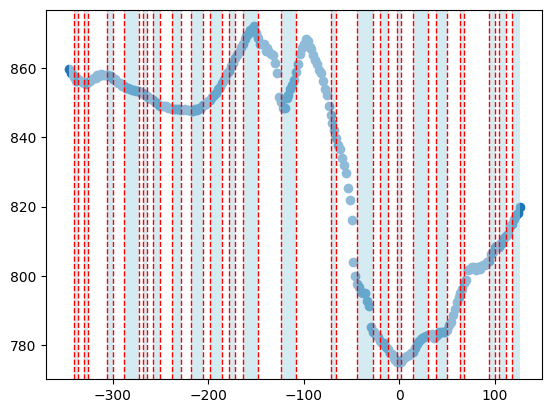

In [44]:
labels, bps = profile_curvature_peaks(-sample['curvature'].values)
plot_segments(sample['alpha'], sample['conditioned_dem'], labels, bps)

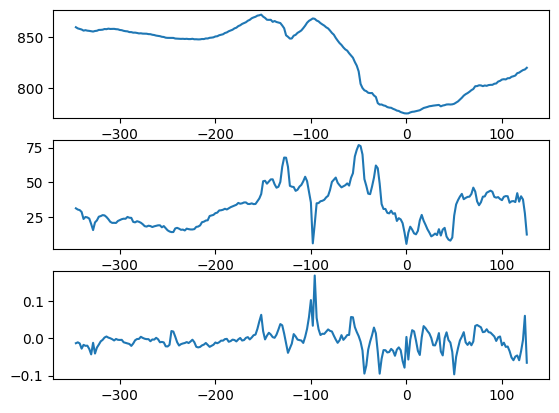

In [45]:
fig, axes = plt.subplots(3)
axes[0].plot(sample['alpha'], sample['conditioned_dem'])
axes[1].plot(sample['alpha'], sample['slope'])
axes[2].plot(sample['alpha'], sample['curvature'])

In [48]:
# where does the mean slope from thalweg to breakpoint exceed 10 degrees? -- one way of handling terraces
sample['slope']

68998    31.411251
68997    30.528194
68996    30.139425
68995    28.785986
68994    23.758106
           ...    
73032    36.197933
73030    40.051456
73038    37.762321
73037    27.783234
73023    12.613914
Name: slope, Length: 237, dtype: float32

In [46]:
# slope units

# starting from floor
labels

array([ 0,  0,  0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19,
       19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27,
       27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30,
       30, 30, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
       33, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36,
       36, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39,
       39, 39, 40, 40, 41

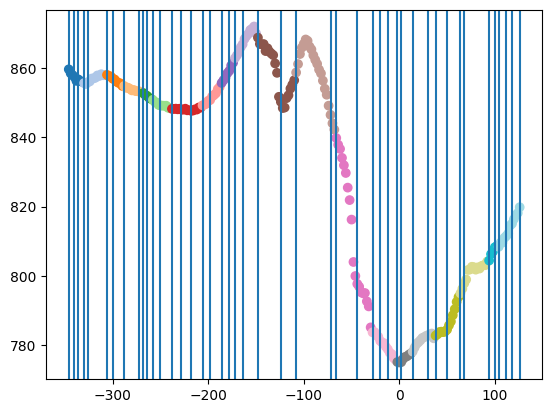

In [100]:
plt.scatter(sample['alpha'], sample['conditioned_dem'], cmap='tab20', c=labels)
for bp in bps:
    plt.axvline(x=sample['alpha'].iat[bp])

In [101]:
sample['labels'] = labels

In [111]:
ms = sample.groupby('labels').mean("slope")["slope"]

In [109]:
import seaborn as sns

In [117]:
mean_slopes = []
for label in sample['labels']:
    mean_slope = ms.loc[label]
    mean_slopes.append(mean_slope)
sample['mean_slopes_by_label'] = mean_slopes
sample['mean_slopes_class'] = sample['mean_slopes_by_label'] < 10
sample

,geom,pointID,streamID,xsID,alpha,conditioned_dem,hand,slope,curvature,hillslope,flowpaths,labels,mean_slopes_by_label,mean_slopes_class
68998,POINT (394043.968 3790627.35),71253,10.0,52,-346,859.533630,66.073608,31.411251,-0.013261,1.0,NaN,0,30.692957,False
68997,POINT (394042.554 3790625.936),71254,10.0,52,-344,858.381287,64.921265,30.528194,-0.010880,1.0,NaN,0,30.692957,False
68996,POINT (394041.14 3790624.521),71255,10.0,52,-342,857.872559,64.412537,30.139425,-0.013837,1.0,NaN,0,30.692957,False
68995,POINT (394039.725 3790623.107),71256,10.0,52,-340,857.304504,63.844482,28.785986,-0.027735,1.0,NaN,1,26.272045,False
68994,POINT (394038.311 3790621.693),71257,10.0,52,-338,856.208923,62.748901,23.758106,-0.017659,1.0,NaN,1,26.272045,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73032,POINT (393715.87 3790299.252),71485,10.0,52,118,815.083557,40.937561,36.197933,-0.058789,2.0,NaN,43,30.881771,False
73030,POINT (393714.456 3790297.838),71486,10.0,52,120,816.384583,42.238586,40.051456,-0.034661,2.0,NaN,43,30.881771,False
73038,POINT (393713.042 3790296.424),71487,10.0,52,122,817.549622,43.403625,37.762321,-0.004606,2.0,NaN,43,30.881771,False
73037,POINT (393711.628 3790295.01),71488,10.0,52,124,818.133728,43.987732,27.783234,0.060179,2.0,NaN,43,30.881771,False


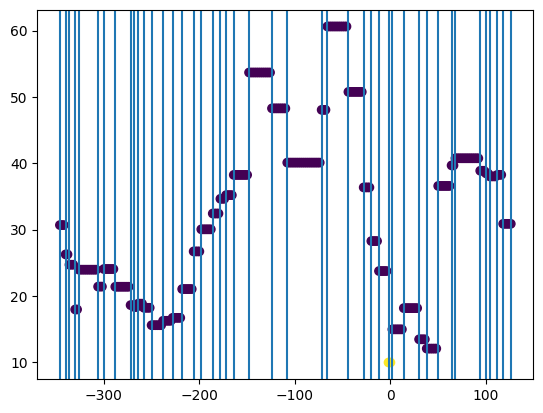

In [122]:
plt.scatter(sample['alpha'], sample['mean_slopes_by_label'], c=sample['mean_slopes_class'])
for bp in bps:
    plt.axvline(x=sample['alpha'].iat[bp])